In this notebook, we will train a simple logistic regression model and package it for use in Matlab. 

In [25]:
%pip install imblearn

   ---------------------------------------- 0.0/235.6 kB ? eta -:--:--
   ----- ---------------------------------- 30.7/235.6 kB 1.3 MB/s eta 0:00:01
   ------------- -------------------------- 81.9/235.6 kB 1.1 MB/s eta 0:00:01
   ------------------------------------ --- 215.0/235.6 kB 1.6 MB/s eta 0:00:01
   ---------------------------------------- 235.6/235.6 kB 1.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import pandas as pd

def combine_csv(folder_path, test_condition):
    """
    Combine all CSV files in a folder into a single DataFrame.
    :param folder_path: Path to the folder containing the CSV files
    :param seq_idx: Sequence index
    :param label: Label of the sequence (Normal - 0, Abnormal - 1)
    :return: A single DataFrame containing all the data from the CSV files
    """

    # Get a list of all CSV files in the folder
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

    # Create an empty DataFrame to store the combined data
    combined_df = pd.DataFrame()

    # Iterate over the CSV files in the folder
    for file in csv_files:
        # Construct the full path to each CSV file
        file_path = os.path.join(folder_path, file)

        # Read each CSV file into a DataFrame
        df = pd.read_csv(file_path)
        # Drop the time. Will add later.
        df = df.drop(labels=df.columns[0], axis=1)

        # Extract the file name (excluding the extension) to use as a prefix
        file_name = os.path.splitext(file)[0]

        # Add a prefix to each column based on the file name
        df = df.add_prefix(f'{file_name}_')

        # Concatenate the current DataFrame with the combined DataFrame
        combined_df = pd.concat([combined_df, df], axis=1)

    df = pd.read_csv(file_path)
    combined_df = pd.concat([df['time'], combined_df], axis=1)
    combined_df.loc[:, 'test_condition'] = test_condition

    return combined_df
        

In [2]:
# Read the data
path_training = ['static_with_fault_1', 'static_with_fault_2', 'static_with_fault_3', 
'static_with_fault_4', 'static_with_fault_5', 'static_with_fault_6', 
'steady_state_after_movement', 'steady_state_not_moving'
]

path_test = ['task_fault']

# path_header = '../data_collection/collected_data/'
path_header = os.path.abspath('../data_collection/collected_data/')


df = pd.DataFrame()
for tmp_path in path_training:
    # path = path_header + tmp_path
    path = path_header + '/' + tmp_path
    tmp_df = combine_csv(path, tmp_path)
    df = pd.concat([df, tmp_df])
    df = df.reset_index(drop=True)

df_test = pd.DataFrame()
for tmp_path in path_test:
    # path = path_header + tmp_path
    path = path_header + '/' + tmp_path
    tmp_df = combine_csv(path, tmp_path)
    df_test = pd.concat([df_test, tmp_df])
    df_test = df_test.reset_index(drop=True)

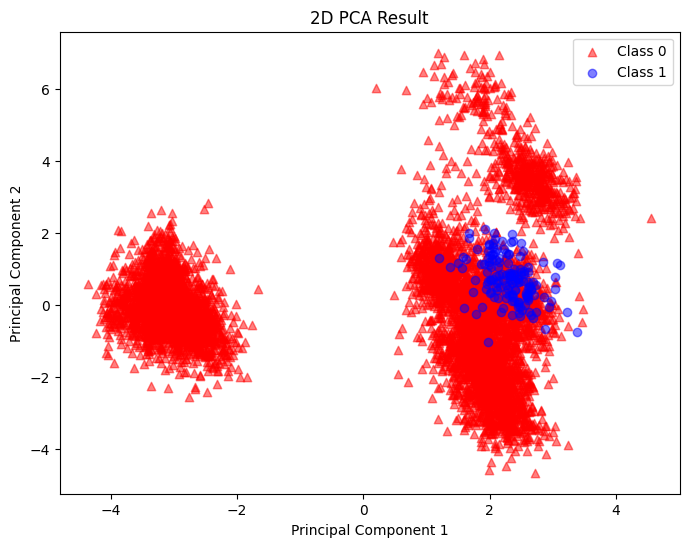

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_features = ['test_condition', 'time', 'data_motor_1_label', 'data_motor_2_label', 'data_motor_3_label', 
             'data_motor_4_label', 'data_motor_5_label', 'data_motor_6_label']
y_feature = 'data_motor_4_label'
# Separate the features (X) and the target variable (y)
X = df.drop(X_features, axis=1)
y = df[y_feature]

X_test_fault = df_test.drop(X_features, axis=1)
y_test_fault = df_test[y_feature]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA to reduce the dimensionality to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='red', marker='^', alpha=.5, label='Class 0')
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='blue', marker='o', alpha=.5, label='Class 1')
plt.title('2D PCA Result')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

### Correlation Matrix

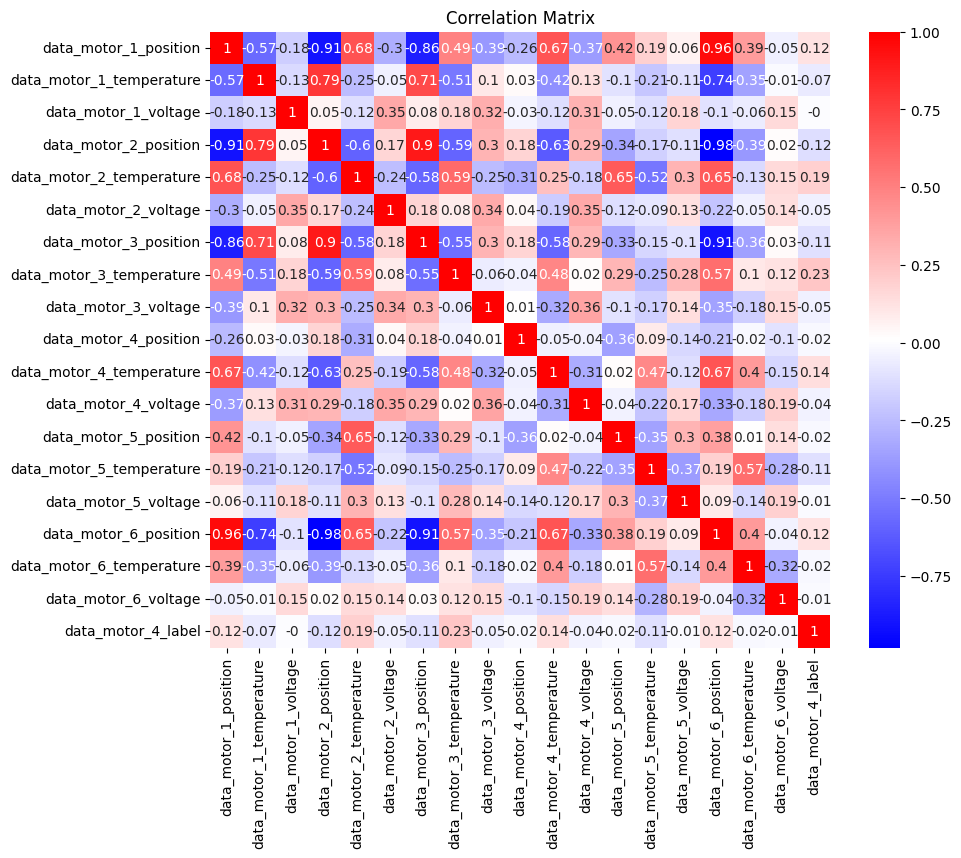

In [4]:
import seaborn as sns

# Concatenate X and y into a single dataframe
df_combined = pd.concat([X, y], axis=1)

# Compute the correlation matrix
corr_matrix = df_combined.corr().round(2)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='bwr')
plt.title('Correlation Matrix')
plt.show()

It looks like the correlation between the X features and the target feature is between -0.21 and +0.23 at best... It's not looking great at first.

### Delete the outliers

In [5]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Standardize the data in X
X_scaled = scaler.fit_transform(X)
X_scaled_test_fault = scaler.fit_transform(X_test_fault)

# Calculate the z-scores for each feature
z_scores = np.abs((X_scaled - X_scaled.mean()) / X_scaled.std())
z_scores_test_fault = np.abs((X_scaled_test_fault - X_scaled_test_fault.mean()) / X_scaled_test_fault.std())

# Define a threshold for outlier detection (e.g., z-score > 3)
threshold = 3

# Identify the indices of outliers
outlier_indices = np.where(z_scores > threshold)[0]
outlier_indices_test_fault = np.where(z_scores_test_fault > threshold)[0]

# Remove the outliers from the dataset
X = X.drop(X.index[outlier_indices])
y = y.drop(y.index[outlier_indices])
X_test_fault = X_test_fault.drop(X_test_fault.index[outlier_indices_test_fault])
y_test_fault = y_test_fault.drop(y_test_fault.index[outlier_indices_test_fault])

### Add the derivative features to the dataset

In [6]:
X_diff = X.diff().fillna(0)
X_diff.columns = [f'{col}_diff' for col in X.columns]
X = pd.concat([X, X_diff], axis=1)

X_test_fault_diff = X_test_fault.diff().fillna(0)
X_test_fault_diff.columns = [f'{col}_diff' for col in X_test_fault.columns]
X_test_fault = pd.concat([X_test_fault, X_test_fault_diff], axis=1)

In [7]:
# Oversample the minority class
from imblearn.over_sampling import SMOTE
print(y.value_counts())
X, y = SMOTE().fit_resample(X, y)
print(y.value_counts())

data_motor_4_label
0    5651
1     147
Name: count, dtype: int64
data_motor_4_label
0    5651
1    5651
Name: count, dtype: int64


### Smoothen the dataset

In [8]:
window_size = 10

X_smoothen = X.rolling(window=window_size, min_periods=1).mean()
X = X_smoothen

X_test_fault_smoothen = X_test_fault.rolling(window=window_size, min_periods=1).mean()
X_test_fault = X_test_fault_smoothen

Text(0.5, 1.0, 'Correlation Matrix')

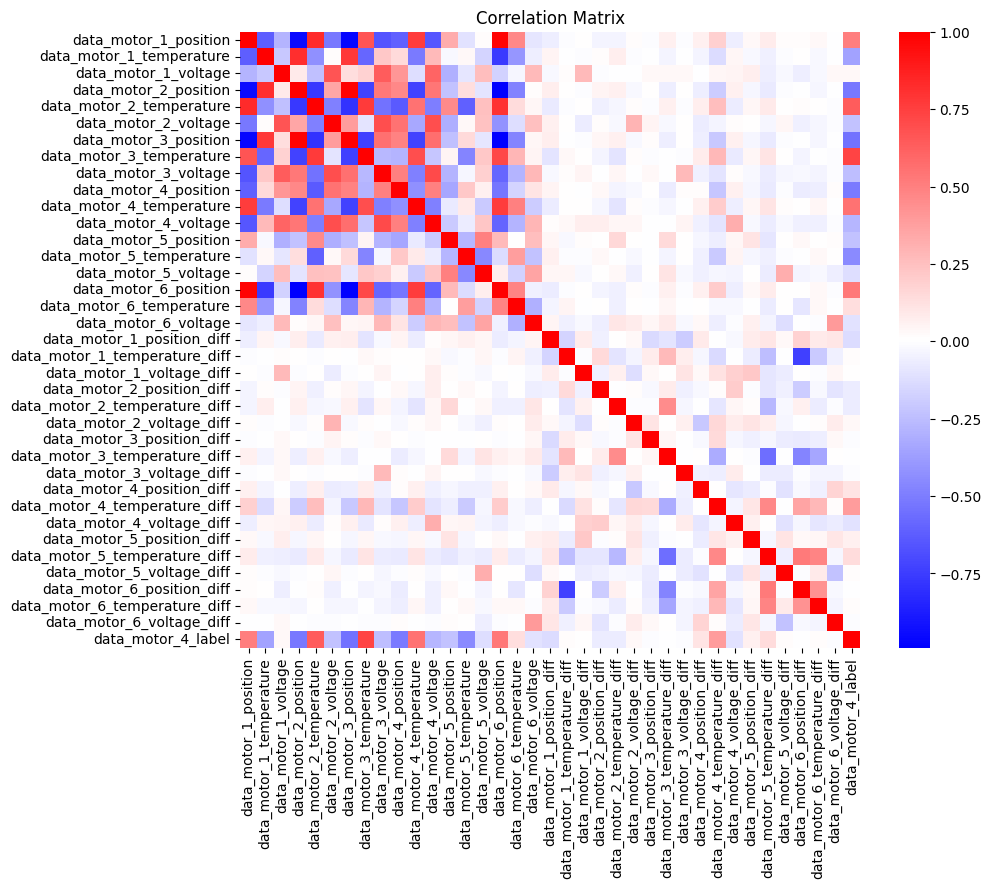

In [9]:
import seaborn as sns

# Concatenate X and y into a single dataframe
df_combined = pd.concat([X, y], axis=1)

# Compute the correlation matrix
corr_matrix = df_combined.corr().round(2)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='bwr')
plt.title('Correlation Matrix')


In [56]:
X

,data_motor_1_position,data_motor_1_temperature,data_motor_1_voltage,data_motor_2_position,data_motor_2_temperature,data_motor_2_voltage,data_motor_3_position,data_motor_3_temperature,data_motor_3_voltage,data_motor_4_position,...,data_motor_3_voltage_diff,data_motor_4_position_diff,data_motor_4_temperature_diff,data_motor_4_voltage_diff,data_motor_5_position_diff,data_motor_5_temperature_diff,data_motor_5_voltage_diff,data_motor_6_position_diff,data_motor_6_temperature_diff,data_motor_6_voltage_diff
0,489.0,50.0,7053.00,501.000000,34.0,7159.00,500.0,29.0,7166.000000,501.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,489.0,50.0,7055.00,501.500000,34.0,7162.50,500.0,29.0,7180.500000,501.0,...,14.500000,0.000000,0.000000,-12.500000,-0.500000,0.000000,-13.500000,0.000000,0.000000,-8.500000
2,489.0,50.0,7060.00,501.666667,34.0,7162.00,500.0,29.0,7187.333333,501.0,...,11.666667,0.000000,0.000000,-8.333333,0.000000,0.000000,-9.000000,0.000000,0.000000,1.666667
3,489.0,50.0,7063.25,501.750000,34.0,7167.25,500.0,29.0,7183.000000,501.0,...,1.000000,0.000000,0.000000,6.000000,-0.500000,0.000000,-0.500000,0.000000,0.000000,-3.750000
4,489.0,50.0,7064.60,501.800000,34.0,7168.80,500.0,29.0,7183.600000,501.0,...,4.000000,0.000000,0.000000,1.800000,-0.200000,0.000000,-6.600000,0.000000,0.000000,-4.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11297,492.0,49.0,7116.80,498.000000,45.4,7187.20,499.0,39.0,7196.300000,501.0,...,-12.778684,-0.128706,0.072323,9.126651,0.212819,-0.049839,8.738265,0.344019,-0.053375,5.491567
11298,492.0,49.0,7113.60,498.000000,45.3,7186.60,499.0,39.0,7190.800000,501.0,...,-16.761401,0.018806,0.126547,16.182703,0.219531,-0.049839,7.783808,0.359180,-0.053375,8.310678
11299,492.0,49.0,7112.90,498.000000,45.2,7187.10,499.0,39.0,7183.000000,501.0,...,-24.388719,-0.081680,0.172686,13.082056,0.319531,-0.049839,12.358048,0.406291,0.000000,9.022850
11300,492.0,49.0,7112.10,498.000000,45.2,7186.70,499.0,39.0,7182.200000,501.0,...,-28.609574,-0.007057,0.172686,14.596822,0.285628,-0.049839,8.886531,0.248721,0.000000,8.243947


In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import joblib
import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore convergence warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a list of classifiers to evaluate
classifiers = [
    ('Logistic Regression', LogisticRegression(class_weight='balanced')),
    ('SVM', SVC(class_weight='balanced')),
    ('Decision Tree', DecisionTreeClassifier(class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(class_weight='balanced')),
    # Add more classifiers here
]

# Define hyperparameters for grid search for each classifier
param_grids = [
    {'C': np.logspace(-1, 1, 5)},  # Hyperparameters for Logistic Regression
    {'C': np.logspace(-1, 1, 5), 'gamma': np.logspace(-1, 1, 5), 'kernel': ['poly'], 'degree': [2,3]}, # Hyperparameters for SVM
    {'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4]},  # Hyperparameters for Decision Tree
    {'n_estimators': [10, 50, 100, 200], 'criterion': ['gini', 'entropy'], 'max_depth': [2, 3, 4]} # Hyperparameters for Random Forest
    # Add more hyperparameters for other classifiers here
]

# Create an empty list to store the results
results = []

# Iterate over the classifiers and perform grid search
for classifier, param_grid in zip(classifiers, param_grids):
    
    # Rename the param_grid keys with the classifier name
    param_grid = {f'{classifier[0]}__{key}': value for key, value in param_grid.items()}

    # Create a pipeline with Standardization and the current classifier
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        classifier
    ])

    # Use GridSearchCV to find the best hyperparameters and fit the pipeline
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', verbose = 3)
    grid_search.fit(X_train, y_train)

    # Use grid_search.predict to make predictions on the testing dataset
    y_pred = grid_search.predict(X_test)

    # Compute evaluation metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Store the results in a dictionary
    result = {
        'Classifier': classifier[0],
        'Best Parameters': grid_search.best_params_,
        'Confusion Matrix': conf_matrix,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

    # Append the result to the list of results
    results.append(result)

    # Save the best model from grid search
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, f'best_model_{classifier[0]}.model')

# Print the results
for result in results:
    print(f"Classifier: {result['Classifier']}")
    print(f"Best Parameters: {result['Best Parameters']}")
    print(f"Confusion Matrix:\n{result['Confusion Matrix']}")
    print(f"Accuracy: {result['Accuracy']}")
    print(f"Precision: {result['Precision']}")
    print(f"Recall: {result['Recall']}")
    print(f"F1 Score: {result['F1 Score']}")
    print()


Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ........Logistic Regression__C=0.1;, score=0.990 total time=   0.2s
[CV 2/5] END ........Logistic Regression__C=0.1;, score=0.987 total time=   0.0s
[CV 3/5] END ........Logistic Regression__C=0.1;, score=0.994 total time=   0.0s
[CV 4/5] END ........Logistic Regression__C=0.1;, score=0.990 total time=   0.0s
[CV 5/5] END ........Logistic Regression__C=0.1;, score=0.991 total time=   0.0s
[CV 1/5] END Logistic Regression__C=0.31622776601683794;, score=0.991 total time=   0.0s
[CV 2/5] END Logistic Regression__C=0.31622776601683794;, score=0.988 total time=   0.0s
[CV 3/5] END Logistic Regression__C=0.31622776601683794;, score=0.995 total time=   0.0s
[CV 4/5] END Logistic Regression__C=0.31622776601683794;, score=0.990 total time=   0.0s
[CV 5/5] END Logistic Regression__C=0.31622776601683794;, score=0.991 total time=   0.0s
[CV 1/5] END ........Logistic Regression__C=1.0;, score=0.990 total time=   0.0s
[CV 2/5] 

KeyboardInterrupt: 

In [11]:
import glob

# Get a list of all .model files in the current directory
model_files = glob.glob('*.model')

# Iterate over the model files
for model_file in model_files:
    # Load the model
    model = joblib.load(model_file)

    # Use the loaded model to make predictions on the test data
    y_pred_fault = model.predict(X_test_fault)

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test_fault, y_pred_fault)
    print(f"Confusion Matrix for {model_file}:")
    print(conf_matrix)

    # Compute accuracy
    accuracy = accuracy_score(y_test_fault, y_pred_fault)
    print(f"Accuracy for {model_file}: {accuracy}")

    # Compute precision
    precision = precision_score(y_test_fault, y_pred_fault)
    print(f"Precision for {model_file}: {precision}")

    # Compute recall
    recall = recall_score(y_test_fault, y_pred_fault)
    print(f"Recall for {model_file}: {recall}")

    # Compute F1 score
    f1 = f1_score(y_test_fault, y_pred_fault)
    print(f"F1 Score for {model_file}: {f1}")

    print()  # Add a blank line between each model's results


Confusion Matrix for best_model_Decision Tree.model:
[[339   1]
 [154  17]]
Accuracy for best_model_Decision Tree.model: 0.6966731898238747
Precision for best_model_Decision Tree.model: 0.9444444444444444
Recall for best_model_Decision Tree.model: 0.09941520467836257
F1 Score for best_model_Decision Tree.model: 0.1798941798941799

Confusion Matrix for best_model_Logistic Regression.model:
[[255  85]
 [ 13 158]]
Accuracy for best_model_Logistic Regression.model: 0.8082191780821918
Precision for best_model_Logistic Regression.model: 0.6502057613168725
Recall for best_model_Logistic Regression.model: 0.9239766081871345
F1 Score for best_model_Logistic Regression.model: 0.7632850241545894

Confusion Matrix for best_model_LR.model:
[[340   0]
 [171   0]]
Accuracy for best_model_LR.model: 0.6653620352250489
Precision for best_model_LR.model: 0.0


d:\Programmes\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Programmes\Anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall for best_model_LR.model: 0.0
F1 Score for best_model_LR.model: 0.0

Confusion Matrix for best_model_Random Forest.model:
[[340   0]
 [171   0]]
Accuracy for best_model_Random Forest.model: 0.6653620352250489
Precision for best_model_Random Forest.model: 0.0
Recall for best_model_Random Forest.model: 0.0
F1 Score for best_model_Random Forest.model: 0.0

Confusion Matrix for best_model_SVM.model:
[[340   0]
 [157  14]]
Accuracy for best_model_SVM.model: 0.6927592954990215
Precision for best_model_SVM.model: 1.0
Recall for best_model_SVM.model: 0.08187134502923976
F1 Score for best_model_SVM.model: 0.15135135135135133



Can you try to train on the training dataset, except for the "task_fault"? And you test on "task_fault" only?

In [14]:
model = joblib.load('best_model_Logistic Regression.model')
# Use the loaded model to make predictions on the test data
y_pred_fault = model.predict(X_test_fault)

<Axes: >

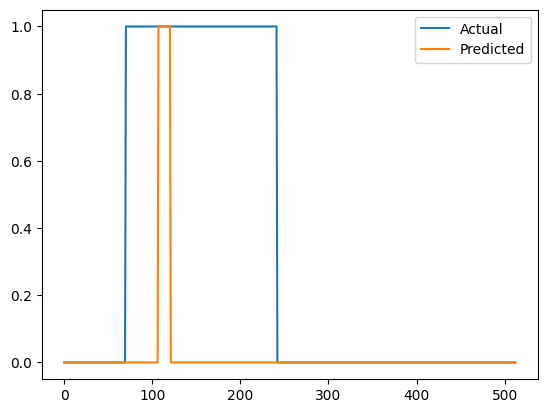

In [15]:
df_result = pd.DataFrame({'Actual': y_test_fault, 'Predicted': y_pred_fault})
df_result.plot()